In [1]:
import numpy as np
import pandas as pd
import sys, os, time
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import ray
sys.path.append('../')


from src.data_structures import FactorGraph, PriorityQueue
from src.sampling_algorithms.factor_components import (gaussian_bounce, chain_bounce_fn, 
                                                       gaussian_grad_potential_fn, 
                                                       gaussian_chain_grad_potential_fn,
                                                           logistic, 
                                                       generate_logistic_bounce, 
                                                       alias_sample, 
                                                       lambda_r, 
                                                       grad_logistic, 
                                                       lambda_bound
                                                      )
from src.utils import (interp, get_xtv, get_first_moment, get_second_moment, get_var)
from src.utils.serialize import pickle_obj, unpickle_obj
from src.sampling_algorithms import MaskedLocalBPS, LocalBPS
from src.mcmc_diagnostics.diagnostic import MCMCDiagnostic
from src.sampling_algorithms.masked_bps.masked_bps_output import OutputReader

from src.utils.serialize import pickle_obj, unpickle_obj, load_json, save_json
from src.utils.params import hash_dict
from src.plots.arrow_plot import arrow_plot
from arviz.stats import ess

from matplotlib import rc
rc('text', usetex=False)
import shutil

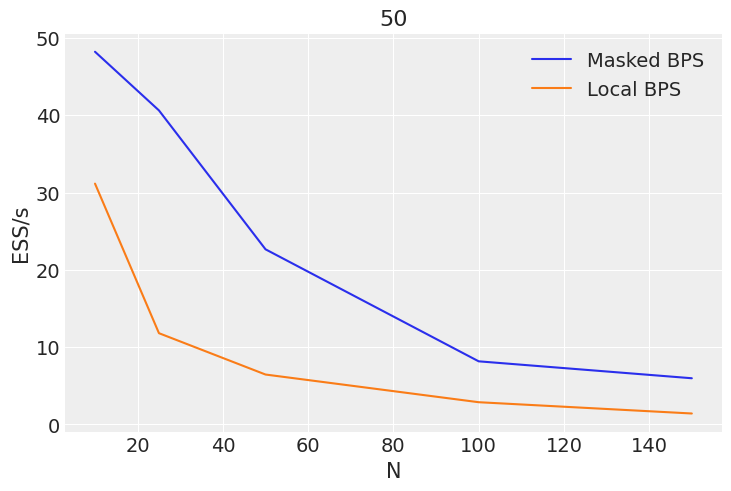

In [8]:
n = [10, 25, 50, 100, 150]
masked = [48.21, 40.62, 22.65, 8.16, 5.97]
local =  [31.15, 11.80, 6.451, 2.87, 1.41]
nuts =  [0.78, 0.31, 0.167, 0.07, 0.05]

plt.plot(n,masked, label='Masked BPS')
plt.plot(n,local, label='Local BPS')
plt.title(d)
plt.xlabel('N')
plt.ylabel('ESS/s')
plt.legend()
plt.show()


In [166]:
maps = {
    'local' : "Local BPS",
    'masked' : "Masked BPS",
    'nuts': 'NUTS'
}

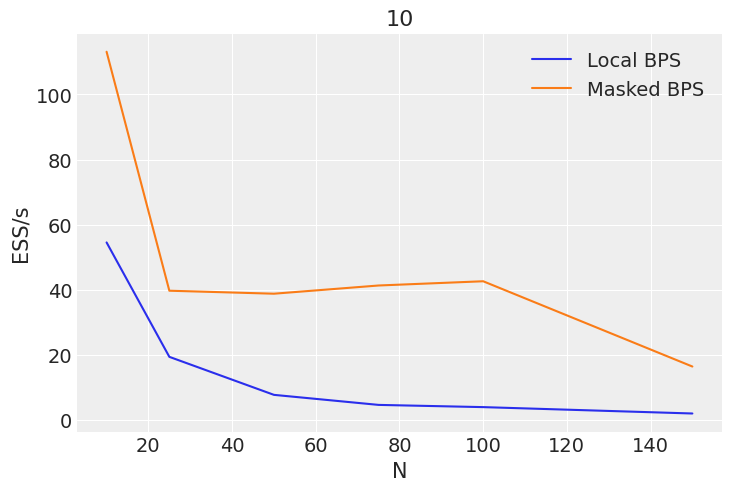

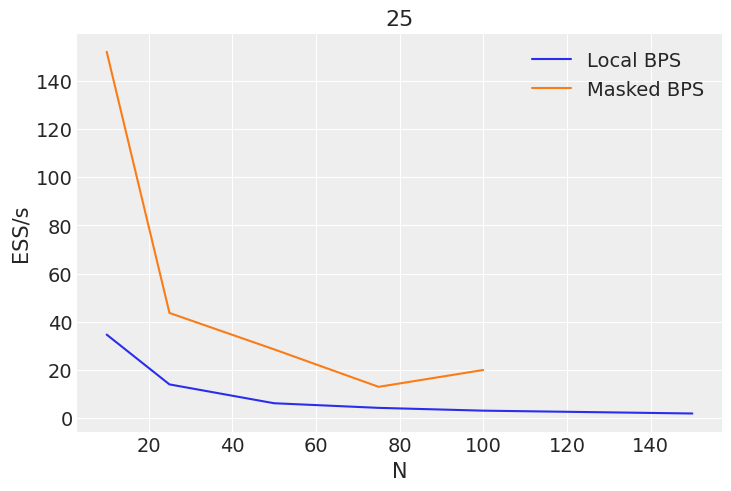

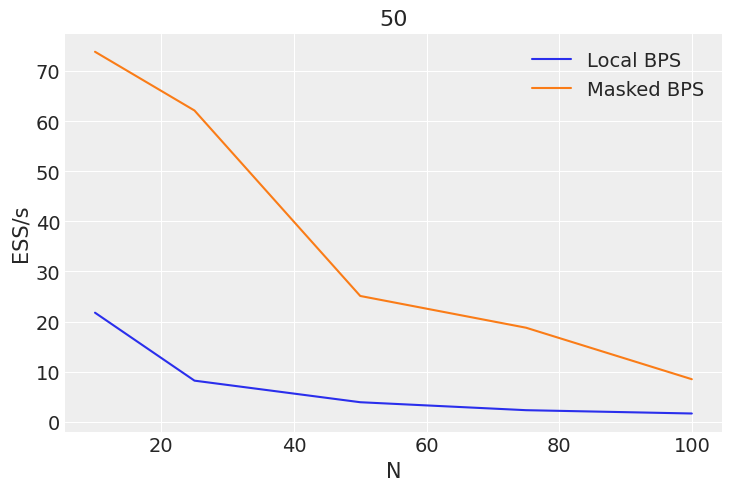

In [118]:
agg_results = []
num_workers = 15
refresh_rate = 0.001
output_dir = '.'
run_time = 30


for d in [10, 25, 50]:
    for T in [10, 25, 50, 75, 100, 150]:
        for method in ['local', 'masked']:
            num_cuts= min(12, T//5)

            params = {
                'd' : d,
                'T' : T,
                'num_workers': num_workers,
                'refresh_rate' : refresh_rate,
                'num_cuts' : num_cuts,
                'seed': 123,
                'method': method
            }
            # run masked bps
            model_output_dir = os.path.join(output_dir)

            if not os.path.exists(model_output_dir):
                    os.mkdir(model_output_dir)

            ## set up output dir
            param_hash = hash_dict(params)
            dir_name = "experiment_{0}".format(param_hash)
            dir_path = os.path.join(model_output_dir, dir_name)
            if not os.path.exists(dir_path):
                os.mkdir(dir_path)
                
            if 'results.pkl' in os.listdir(dir_path):    
                params = unpickle_obj(os.path.join(dir_path, 'params.pkl'))
                res = unpickle_obj(os.path.join(dir_path, 'results.pkl'))
                agg_results.append({**params, **res})

df = pd.DataFrame(agg_results)

df

maps = {
    'local' : "Local BPS",
    'masked' : "Masked BPS"
}
for d in [10, 25, 50]:
    for m in ['local', 'masked']:
        rview = df.method == m
        rview2 = df.d == d
        df_plot = df[rview & rview2]
        plt.plot(df_plot['T'], df_plot.ess_speed, label=maps[m])
    plt.title(d)
    plt.xlabel('N')
    plt.ylabel('ESS/s')
    plt.legend()
    plt.show()


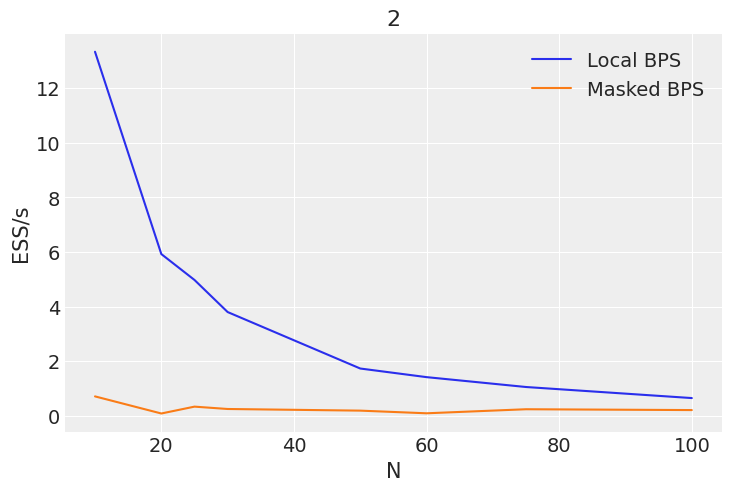

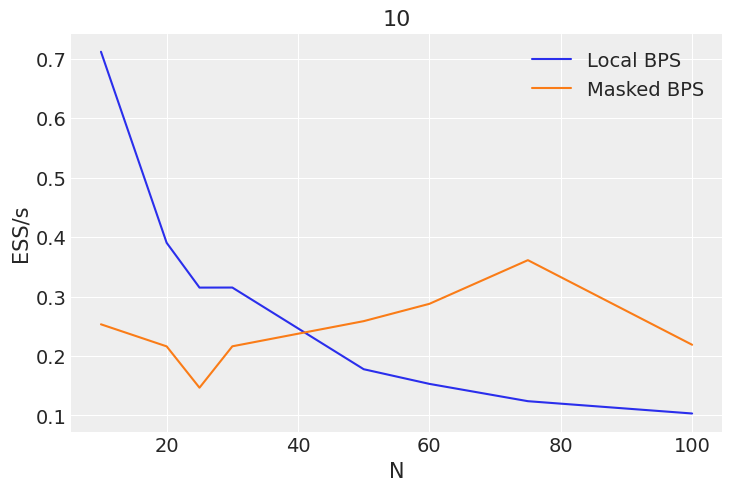

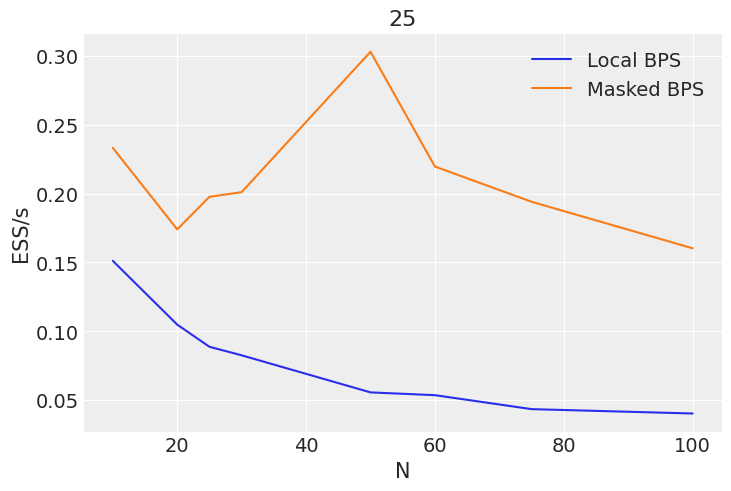

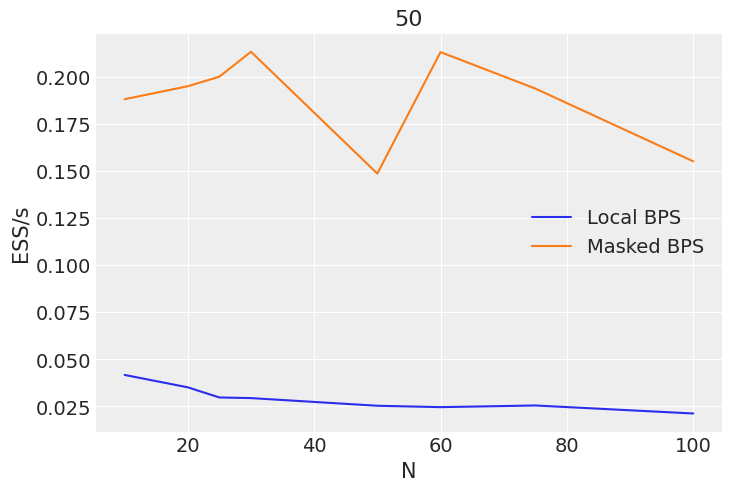

In [23]:
num_workers = 15
refresh_rate = 0.001
output_dir = '.'
run_time = 30
agg_results = []



for d in [2, 10, 25, 50]:#, 25, 50]:
    for G in [10, 20, 25, 30, 50, 60, 75, 100]:
        for method in ['local', 'masked']:#, 'masked']:
            N = 10 * d

            params = {
                'd' : d,
                'G' : G,
                'num_workers': num_workers,
                'refresh_rate' : refresh_rate,
                'seed': 123,
                'method': method,
                'model': 'hierarchical_logistic'
            }
            seed = params['seed']

            # run masked bps
            model_output_dir = os.path.join(output_dir)

            if not os.path.exists(model_output_dir):
                    os.mkdir(model_output_dir)

            ## set up output dir
            param_hash = hash_dict(params)
            dir_name = "experiment_{0}".format(param_hash)
            dir_path = os.path.join(model_output_dir, dir_name)
            if not os.path.exists(dir_path):
                os.mkdir(dir_path)
                
            if 'results.pkl' in os.listdir(dir_path):
                params = unpickle_obj(os.path.join(dir_path, 'params.pkl'))
                res = unpickle_obj(os.path.join(dir_path, 'results.pkl'))
                agg_results.append({**params, **res})
                
df = pd.DataFrame(agg_results)

rview = df.method == 'local'
rview2 = df.d == 25
df_plot = df[rview & rview2 & rview3]

maps = {
    'local' : "Local BPS",
    'masked' : "Masked BPS"
}
for d in [2, 10, 25, 50]:
    for m in ['local', 'masked']:
        rview = df.method == m
        rview2 = df.d == d
        df_plot = df[rview & rview2]
        plt.plot(df_plot['G'], df_plot.ess_speed, label=maps[m])
    plt.title(d)
    plt.xlabel('N')
    plt.ylabel('ESS/s')
    plt.legend()
    plt.show()

In [25]:
df[df.method == 'masked']

,d,G,num_workers,refresh_rate,seed,method,model,ess_speed
1,2,10,15,0.001,123,masked,hierarchical_logistic,0.717218
3,2,20,15,0.001,123,masked,hierarchical_logistic,0.091241
5,2,25,15,0.001,123,masked,hierarchical_logistic,0.342255
7,2,30,15,0.001,123,masked,hierarchical_logistic,0.256171
9,2,50,15,0.001,123,masked,hierarchical_logistic,0.195981
11,2,60,15,0.001,123,masked,hierarchical_logistic,0.098814
13,2,75,15,0.001,123,masked,hierarchical_logistic,0.246988
15,2,100,15,0.001,123,masked,hierarchical_logistic,0.216450
17,10,10,15,0.001,123,masked,hierarchical_logistic,0.253232
19,10,20,15,0.001,123,masked,hierarchical_logistic,0.216097


In [181]:
agg_results = []
paths = os.listdir(model_output_dir)
for path in paths:
    dir_path = os.path.join(model_output_dir, path)
    if "experiment_" in path:
        if ('results.pkl' in os.listdir(dir_path)) & ('params.pkl' in os.listdir(dir_path)):    
            params = unpickle_obj(os.path.join(dir_path, 'params.pkl'))
            res = unpickle_obj(os.path.join(dir_path, 'results.pkl'))
            agg_results.append({**params, **res})
        

In [176]:
agg_results = []
paths = os.listdir(model_output_dir)
for path in paths:
    dir_path = os.path.join(model_output_dir, path)
    if "experiment_" in path:
        if ('results.pkl' in os.listdir(dir_path)) & ('params.pkl' not in os.listdir(dir_path)):    
            #params = unpickle_obj(os.path.join(dir_path, 'params.pkl'))
            res = unpickle_obj(os.path.join(dir_path, 'results.pkl'))
            agg_results.append({**res})
        

In [182]:
df = pd.DataFrame(agg_results)

In [60]:
import seaborn as sns


In [97]:
from plotnine import *
from matplotlib import rcParams
rcParams.update({"figure.max_open_warning": 0,
                 "savefig.bbox": "tight"})

In [187]:
df[df.model=='hierarchical_logistic']

,d,T,num_workers,refresh_rate,num_cuts,seed,method,model,ess_speed,G
5,25,NaN,15,0.001,NaN,123,masked,hierarchical_logistic,0.197620,25.0
11,25,NaN,15,0.001,NaN,123,local,hierarchical_logistic,0.050222,70.0
12,50,NaN,15,0.001,NaN,123,local,hierarchical_logistic,0.029778,25.0
13,50,NaN,15,0.001,NaN,123,local,hierarchical_logistic,0.024640,60.0
15,10,NaN,15,0.001,NaN,123,masked,hierarchical_logistic,0.216215,30.0
...,...,...,...,...,...,...,...,...,...,...
326,2,NaN,15,0.001,NaN,123,local,hierarchical_logistic,4.977319,25.0
330,10,NaN,15,0.001,NaN,123,masked,hierarchical_logistic,0.177911,70.0
335,10,NaN,15,0.001,NaN,123,local,hierarchical_logistic,0.125932,80.0
341,25,NaN,15,0.001,NaN,123,local,hierarchical_logistic,0.040447,100.0


('masked', 10)
       ess_speed
G               
10.0         NaN
20.0    0.234665
25.0    0.181323
30.0    0.181382
40.0    0.192714
50.0    0.213885
60.0    0.273122
70.0    0.232799
75.0    0.269550
80.0    0.281531
100.0   0.210340
('local', 10)
       ess_speed
G               
10.0         NaN
20.0    0.547024
25.0    0.352699
30.0    0.315054
40.0    0.284845
50.0    0.216123
60.0    0.165317
70.0    0.141506
75.0    0.126941
80.0    0.124890
100.0   0.114533


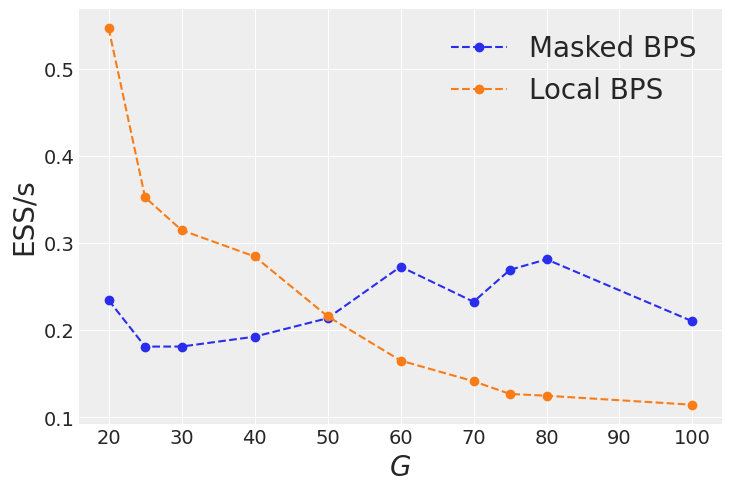

('masked', 25)
       ess_speed
G               
10.0         NaN
20.0    0.203576
25.0    0.185823
30.0    0.199321
40.0    0.233451
50.0    0.284369
60.0    0.261220
70.0    0.218789
75.0    0.206012
80.0    0.194476
100.0   0.177607
('local', 25)
       ess_speed
G               
10.0         NaN
20.0    0.128059
25.0    0.096880
30.0    0.085750
40.0    0.079167
50.0    0.065719
60.0    0.054749
70.0    0.051980
75.0    0.046915
80.0    0.046596
100.0   0.045015


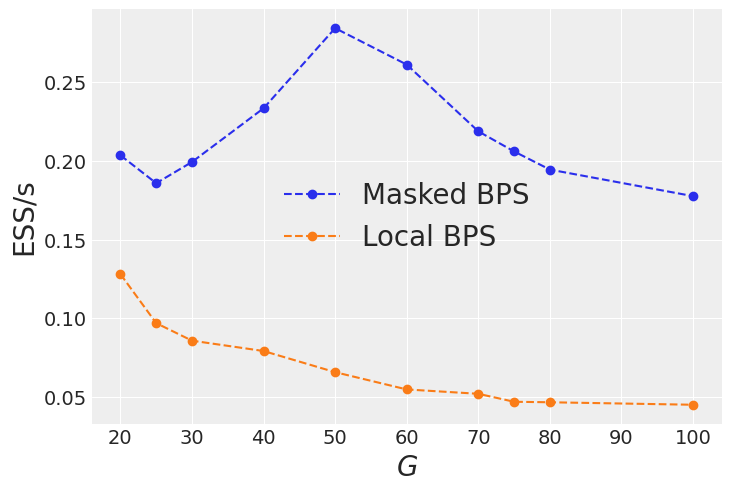

('masked', 50)
       ess_speed
G               
10.0         NaN
20.0    0.191543
25.0    0.197514
30.0    0.206665
40.0    0.198470
50.0    0.166137
60.0    0.180864
70.0    0.173837
75.0    0.164166
80.0    0.158819
100.0   0.139502
('local', 50)
       ess_speed
G               
10.0         NaN
20.0    0.038452
25.0    0.032470
30.0    0.029612
40.0    0.027886
50.0    0.025854
60.0    0.025011
70.0    0.024842
75.0    0.025284
80.0    0.024499
100.0   0.022371


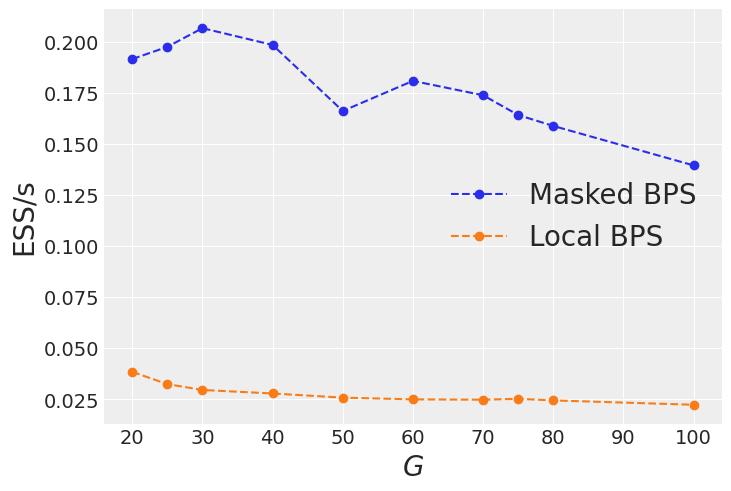

('masked', 2)
       ess_speed
G               
10.0         NaN
20.0    0.404230
25.0    0.216748
30.0    0.299213
40.0    0.280360
50.0    0.250265
60.0    0.147397
70.0    0.147953
75.0    0.222040
80.0    0.398119
100.0   0.382850
('local', 2)
       ess_speed
G               
10.0         NaN
20.0    9.625775
25.0    5.451012
30.0    4.390232
40.0    3.254634
50.0    2.221440
60.0    1.579093
70.0    1.280773
75.0    1.100224
80.0    1.033601
100.0   0.831282


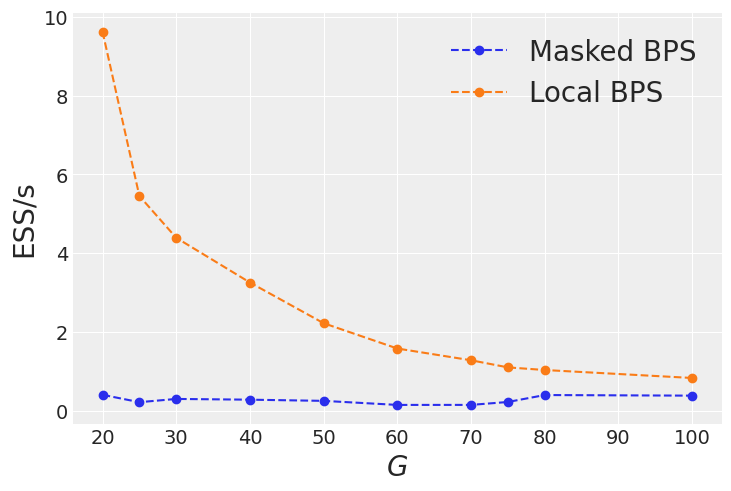

In [208]:
fs=20
for d in df.d.unique():
    for m in ['masked', 'local']:
    
        rview1 = df.d==d
        rview2 = df.method == m
        rview3 = df.model == 'hierarchical_logistic'
        rview5 = df['G'] <= 100.
        
        plot_df = df[rview1&rview2 & rview3 & rview5].copy()
        series = plot_df.groupby('G').agg({'ess_speed':'mean'}).rolling(2).mean()
        plt.plot(series, label=maps[m], linestyle='--', marker='o')#+'(d={0})'.format(d))
        print((m,d))
        print(series)
    plt.legend(prop={'size': fs})
    plt.xlabel('$G$', fontsize=fs)
    plt.ylabel('ESS/s', fontsize=fs)
    #plt.show()
    plt.savefig("hierarchy_d{0}.png".format(d), 
               bbox_inches='tight', 
               transparent=False,
               pad_inches=0)
    plt.show()


('masked', 10)
        ess_speed
T                
10.0   126.748105
25.0    74.766932
50.0    67.682224
75.0    47.070730
100.0   35.026387
('local', 10)
       ess_speed
T               
10.0   47.894726
25.0   18.023125
50.0    8.705769
75.0    5.691291
100.0   3.875124


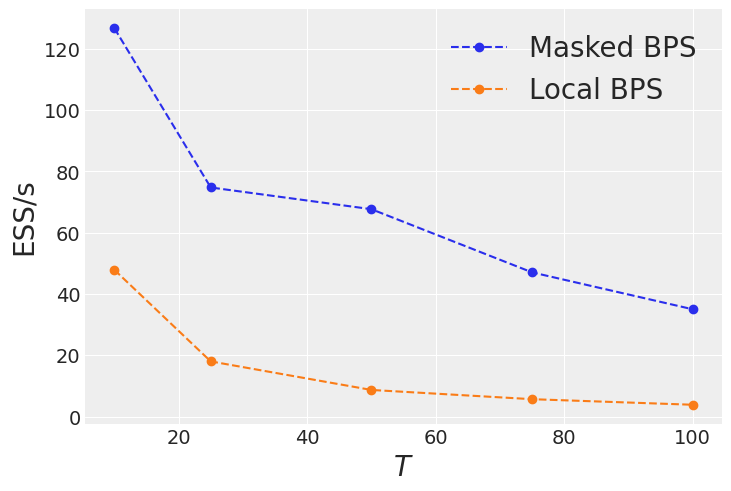

('masked', 25)
        ess_speed
T                
10.0   152.175254
25.0    43.635083
50.0    28.514556
75.0    12.931542
100.0   12.931542
('local', 25)
       ess_speed
T               
10.0   34.631079
25.0   13.943295
50.0    6.118617
75.0    4.193557
100.0   3.032501


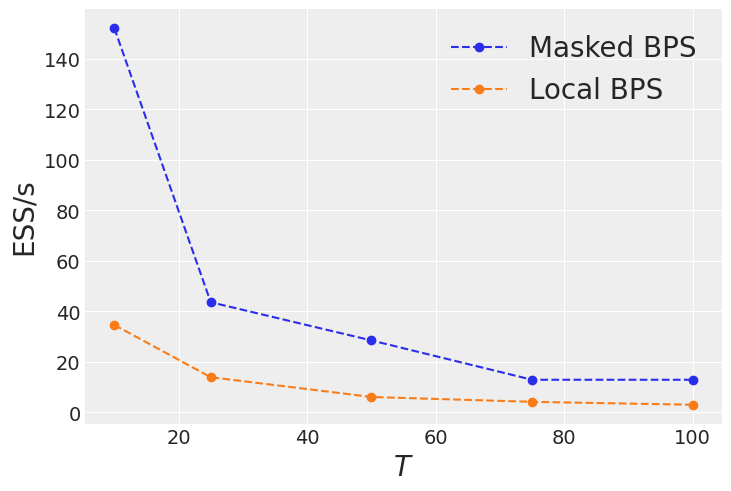

('masked', 50)
       ess_speed
T               
10.0   73.908791
25.0   62.170082
50.0   25.106139
75.0   18.762332
100.0   8.470847
('local', 50)
       ess_speed
T               
10.0   21.764918
25.0    8.185325
50.0    3.872838
75.0    2.282365
100.0   1.620576


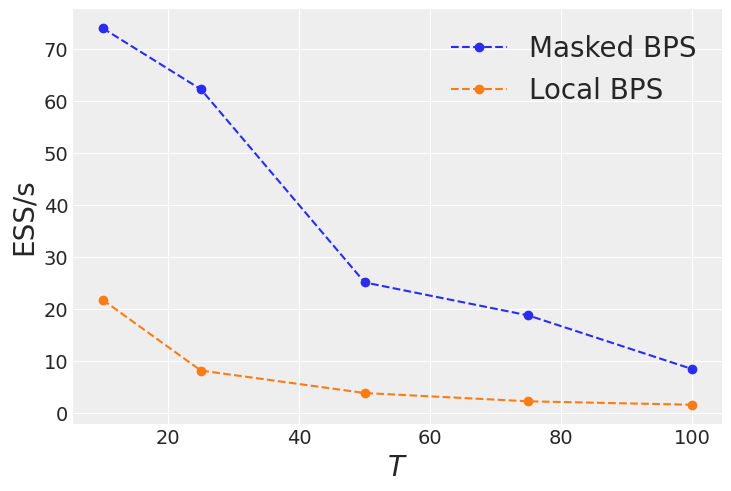

In [206]:
fs=20
for d in [10, 25, 50]:
    for m in ['masked', 'local']:
    
        rview1 = df.d==d
        rview2 = df.method == m
        rview3 = df.model != 'hierarchical_logistic'
        rview4 = df.num_cuts == np.minimum(12, df['T']//5)
        rview5 = df['T'] <= 100
        
        plot_df = df[rview1&rview2 & rview3 & rview4 & rview5].copy()
        series = np.minimum.accumulate(plot_df.groupby('T').agg({'ess_speed':'mean'}))
        plt.plot(series, label=maps[m], linestyle='--', marker='o')#+'(d={0})'.format(d))
        print((m,d))
        print(series)
    plt.legend(prop={'size': fs})
    plt.xlabel('$T$', fontsize=fs)
    plt.ylabel('ESS/s', fontsize=fs)
    #plt.show()
    plt.savefig("chain_d{0}.png".format(d), 
               bbox_inches='tight', 
               transparent=False,
               pad_inches=0)
    plt.show()



In [102]:
plot.save('test.png', bbox_inches= 'tight')

/home/james/miniconda3/envs/bps/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/james/miniconda3/envs/bps/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: test.png
